In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import matplotlib

#=========================================================
'''載入資料'''
def GetNewDataByPandas():
    wine = pd.read_excel("wine.xlsx")
    wine['alcohol**2'] = pow(wine["alcohol"], 2)
    wine['volatileAcidity*alcohol'] = wine["alcohol"] * wine['volatile acidity']
    y = np.array(wine.quality)
    X = np.array(wine.drop("quality", axis=1))
    # X = np.array(wine)

    columns = np.array(wine.columns)

    return X, y, columns



# Read wine quality data from file
X, y, wineNames = GetNewDataByPandas()
# X, y, wineNames = GetDataByPandas()
# split data to [0.8,0.2,01]
x_train, x_predict, y_train, y_predict = train_test_split(X, y, test_size=0.10, random_state=100)


# take fixed holdout set 30% of data rows
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=100)

In [2]:
#=========================================================
'''展示資料'''
wineNames

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality', 'alcohol**2', 'volatileAcidity*alcohol'], dtype=object)

In [3]:
#=========================================================
'''展示資料'''
print(len(x_train),len(y_train))
print(len(x_test))
print(len(x_predict))

1151 1151
288
160


In [4]:
#=========================================================
'''空值填充'''
dtrain = xgb.DMatrix(data=x_train,label=y_train,missing=-999.0)
dtest = xgb.DMatrix(data=x_test,label=y_test,missing=-999.0)

# w = np.random.rand(5, 1)
# dtrain = xgb.DMatrix(x_train, label=y_train, missing=-999.0, weight=w)

In [5]:
#=========================================================
'''設置Booster引數'''
param = {'max_depth': 7, 'eta': 1, 'silent': 1, 'objective': 'reg:linear','nthread':4,'seed':100}

#=========================================================
'''指定設定為監視效能的驗證'''
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [6]:
#=========================================================
'''訓練'''
num_round = 10
bst_without_evallist = xgb.train(param, dtrain, num_round)

num_round = 10
bst_with_evallist = xgb.train(param, dtrain, num_round, evallist)

#=========================================================
'''訓練'''
bst_with_evallist_and_early_stopping_10 = xgb.train(param, dtrain, num_round*100, evallist,early_stopping_rounds=10)

#=========================================================
'''訓練'''
bst_with_evallist_and_early_stopping_100 = xgb.train(param, dtrain, num_round*100, evallist,early_stopping_rounds=100)

[15:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

In [7]:
#=========================================================
'''模型持久化'''
# bst_with_evallist.save_model('bst_with_evallist_0001.model')

# # 載入已儲存的模型
# models_path = ""
# bst_with_evallist = xgb.Booster({'nthread': 4})  # init model
# bst_with_evallist.load_model(models_path+'bst_with_evallist_0001.model')  # load data

'模型持久化'

In [8]:
#=========================================================
'''預測結果'''
dpredict = xgb.DMatrix(x_predict)
# 啥都沒有
ypred_without_evallist = bst_without_evallist.predict(dpredict)
# 沒有早停
ypred_with_evallist = bst_with_evallist.predict(dpredict)
#有早停
ypred_with_evallist_and_early_stopping_100 = bst_with_evallist_and_early_stopping_100.predict(dpredict,ntree_limit=bst_with_evallist_and_early_stopping_100.best_ntree_limit)


#=========================================================
'''測試誤差'''
from sklearn.metrics import mean_squared_error
print("RMSE of bst_without_evallist ：", np.sqrt(mean_squared_error(y_true=y_predict,y_pred=ypred_without_evallist)))

print("RMSE of bst_with_evallist ：", np.sqrt(mean_squared_error(y_true=y_predict,y_pred=ypred_with_evallist)))

print("RMSE of bst_with_evallist_and_early_stopping_100 ：", np.sqrt(mean_squared_error(y_true=y_predict,y_pred=ypred_with_evallist_and_early_stopping_100)))

RMSE of bst_without_evallist ： 0.7115641335422944
RMSE of bst_with_evallist ： 0.7115641335422944
RMSE of bst_with_evallist_and_early_stopping_100 ： 0.7051095123788059


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

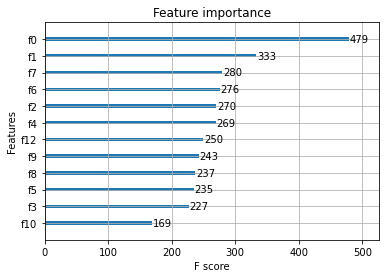

In [9]:
#=========================================================
'''顯示重要因素'''
xgb.plot_importance(bst_with_evallist_and_early_stopping_100)